# Model Iteration 2

In model iteration 2, I'm going to revise my model based on the ideas of another data scientist. 

Below is a list of sources that gives me inspiration:

https://www.dataquest.io/mission/75/improving-your-submission

http://elenacuoco.altervista.org/blog/archives/1195

https://inclass.kaggle.com/c/deloitte-tackles-titanic/forums/t/9841/getting-high-scores-without-looking-at-actual-data-set

I will first follow some steps used in Kaggles tutorials on Random Forest model.

## First Step
Setup the data, including data importing and data cleaning 

In [461]:
import numpy as np
import pandas as pd
import sklearn
import seaborn as sns
sns.set_style('whitegrid')

# reading train and test data
titanic = pd.read_csv("train.csv")
titanic_test = pd.read_csv("test.csv")

# Set up predictors
predictors = ["Pclass", "Sex", "Age", "SibSp", "Parch", "Fare", "Embarked"]

def data_clean(df):
    """
    Do data cleaning for a given data frame,
    including fill "NaN" in "Age" with median 
    and "Nan" in "Embarked" with mode "S",
    and encoding "Sex" to 0 and 1, "Embarked"
    to 0, 1 and 2 to correspond to "S", "Q"
    and "C"
    """

    df["Age"] = df["Age"].fillna(df["Age"].median())
    df["Fare"] = df["Fare"].fillna(df["Fare"].median())
    
    # Replace all the occurences of male with the number 0.
    df.loc[df["Sex"] == "male", "Sex"] = 0
    df.loc[df["Sex"] == "female", "Sex"] = 1

    df["Embarked"] = df["Embarked"].fillna("S")

    df.loc[df["Embarked"] == "S", "Embarked"] = 0
    df.loc[df["Embarked"] == "Q", "Embarked"] = 1
    df.loc[df["Embarked"] == "C", "Embarked"] = 2

data_clean(titanic_test)
data_clean(titanic)

## Random Forest
Construct a random forest and generate cross validated predictions on our dataset. I also tuned the parameters of function RandomForestClassifier() to reduce the effect of overfitting.

In [462]:
from sklearn import cross_validation
from sklearn.ensemble import RandomForestClassifier

# Initialize our algorithm with the default paramters
# n_estimators is the number of trees we want to make
# min_samples_split is the minimum number of rows we need to make a split
# min_samples_leaf is the minimum number of samples we can have at the place where a tree branch ends (the bottom points of the tree)
alg_rf = RandomForestClassifier(random_state=1, n_estimators=100, min_samples_split=40, min_samples_leaf=20)

def train_score(alg, predictors):
    """
    Evaluate the performance of a given
    algorithm on Titanic's train dataset
    
    Using cross validation to reduce 
    overfitting issue
    """
    
    scores = cross_validation.cross_val_score(alg, titanic[predictors], titanic["Survived"], cv=3)
    print(scores.mean())

# test the random forest algorithm
train_score(alg_rf, predictors)

0.775533108866


## Finding the best features
Feature engineering is the most important part of any machine learning task, and there are lots more features we could calculate. But we also need a way to figure out which features are the best. To evaluate features, I will use univariate feature selection. This essentially goes column by column, and figures out which columns correlate most closely with what we're trying to predict

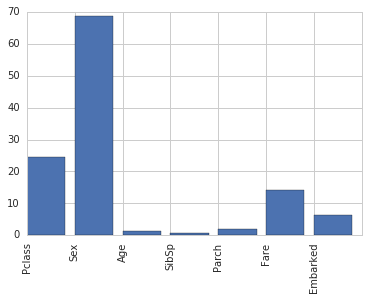

In [463]:
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.feature_selection import SelectKBest, f_classif


def best_feature(df, predictors):
    """
    Evaluate each features and plot a diagram of
    each variable's correlation.
    
    Using univariate feature selection to 
    figures out which columns correlate most closely 
    with what we're trying to predict
    """
    
    # Perform feature selection
    selector = SelectKBest(f_classif, k=5)
    selector.fit(df[predictors], df["Survived"])
    
    # Get the raw p-values for each feature, and transform from p-values into scores
    scores = -np.log10(selector.pvalues_)

    # Plot the scores.  See how "Pclass", "Sex", "Title", and "Fare" are the best?
    plt.bar(range(len(predictors)), scores)
    plt.xticks(range(len(predictors)), predictors, rotation='vertical')
    plt.show()
    
best_feature(titanic, predictors)

## Ensembling with Gradient Boosting

One thing we can do to improve the accuracy of our predictions is to ensemble different classifiers. Ensemblingh means that we generate predictions using information from a set of classifiers, instead of just one. In practice, this means that we average their predictions.

Generally, the more diverse the models we ensemble, the higher our accuracy will be. Diversity means that the models generate their results from different columns, or use a very different method to generate predictions. Ensembling a random forest classifier with a decision tree probably won't work extremely well, because they are very similar. On the other hand, ensembling a linear regression with a random forest can work very well.

Here, I will use logistic regression over some linear variables and use gradient boosting over non-linear features. And finally ensemble them to get merged result. But some important variables like Pclass, Sex and Fare are both included.

In [464]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import KFold

# define list of predictors for Gradient Boosting and Logistic Regression respectively
non_line_preds = ["Pclass", "Sex", "Fare", "Age", "Embarked", "SibSp", "Parch"]
line_preds = ["Pclass", "Sex", "Fare"]

# define Gradient Boosting and Logistic Regression for ensembling
algorithms = [
    [GradientBoostingClassifier(random_state=1, n_estimators=25, max_depth=3), non_line_preds],
    [LogisticRegression(random_state=1), line_preds]
]

def ensemble_train(algs, weight1, weight2):
    """
    Given a list of two algorithms and 
    values of their weights, calculate and print out
    the scores of ensembled prediction with 
    cross validation
    """
    # Initialize the cross validation folds
    kf = KFold(titanic.shape[0], n_folds=3, random_state=1)
    
    predictions = []
    for train, test in kf:
        train_target = titanic["Survived"].iloc[train]
        full_test_predictions = []
        # Make predictions for each algorithm on each fold
        for alg, predictors in algs:
            # Fit the algorithm on the training data.
            alg.fit(titanic[predictors].iloc[train,:], train_target)
            # Select and predict on the test fold.  
            # The .astype(float) is necessary to convert the dataframe to all floats and avoid an sklearn error.
            test_predictions = alg.predict_proba(titanic[predictors].iloc[test,:].astype(float))[:,1]
            full_test_predictions.append(test_predictions)
        # The gradient boosting classifier generates better predictions, so we weight it higher.
        test_predictions = (full_test_predictions[0] * weight1 + full_test_predictions[1] * weight2) / (weight1 + weight2)
        # Any value over .5 is assumed to be a 1 prediction, and below .5 is a 0 prediction.
        test_predictions[test_predictions <= .5] = 0
        test_predictions[test_predictions > .5] = 1
        predictions.append(test_predictions)

    # Put all the predictions together into one array.
    predictions = np.concatenate(predictions, axis=0)
    
    # Compute accuracy by comparing to the training data.
    accuracy = sum(predictions[predictions == titanic["Survived"]]) / len(predictions)
    print(accuracy)

ensemble_train(algorithms, 3, 1)

0.810325476992


/home/yuzhong/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:48: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index


## Making a submission

In [465]:
def submission(predictions):
    """
    Generate a submission file based on the predictions
    """
    submission = pd.DataFrame({
            "PassengerId": titanic_test["PassengerId"],
            "Survived": predictions
        })

    submission.to_csv("titanic_submission.csv", index=False)
    
def ensemble_test(algs, weight1, weight2):
    full_predictions = []
    for alg, predicts in algs:
        # Fit the algorithm using the full training data.
        alg.fit(titanic[predicts], titanic["Survived"])
        # Predict using the test dataset.  We have to convert all the columns to floats to avoid an error.
        predictions = alg.predict_proba(titanic_test[predicts].astype(float))[:,1]
        full_predictions.append(predictions)

    # The gradient boosting classifier generates better predictions, so we weight it higher.
    predictions = (full_predictions[0] * weight1 + full_predictions[1] * weight1) / (weight1 + weight2)

    # Create a new dataframe with only the columns Kaggle wants from the dataset.
    predictions[predictions <= .5] = 0
    predictions[predictions > .5] = 1
    predictions = predictions.astype(int)
    
    return predictions
submission(ensemble_test(algorithms, 3, 1))

From the improvement I made above, I get a score of 0.78469, with an increase of 1 percent. But certainly more progress can be made, therefore I moved to the next step.

## Better Data cleaning and data munge

The inspiration for this section is from source: http://elenacuoco.altervista.org/blog/archives/1195
I used most of his data cleaning code while adding some changes of my own. Including the result I found during model iteration 1. I add a new feature of "HighGroup", a series of boolean indicating whether the passinger is a woman with either Pclass 1 or 2, or old in age. The rationale behind the feature is that aged female has a survival rate near 1.0, women with Pclass 1 has about 0.97 and Pclass 2 has about 0.92. Filtering out these important survival features helps the modeling tools to predict better.

Some good insights that I drawn from the source is that we can use sklearn's preprocessing tool to config catergorical data to numerical datas

In [466]:
import string
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
enc=preprocessing.OneHotEncoder()

def substrings_in_string(big_string, substrings):
    """
    Utility to clean and munge data
    
    returns the substring if it is 
    contained in the big string. set 
    the result to "NaN" if there is no
    match found
    """
    for substring in substrings:
        if string.find(big_string, substring) != -1:
            return substring
    return np.nan


def clean_and_munge_data(df):
    """
    Clean the data for titanic dataset
    and create some new features by either
    combining two already existed features
    or inducting from one specific feature.
    """
    
    # setting silly values to nan and then replace nan with median
    df.Fare = df.Fare.map(lambda x: np.nan if x==0 else x)
    df["Fare"] = df["Fare"].fillna(df["Fare"].median())
    
    # creating a title column from name
    title_list=['Mrs', 'Mr', 'Master', 'Miss', 'Major', 'Rev',
                'Dr', 'Ms', 'Mlle','Col', 'Capt', 'Mme', 'Countess',
                'Don', 'Jonkheer']
    df['Title'] = df['Name'].map(lambda x: substrings_in_string(x, title_list))
    df['Title'] = df['Title'].fillna("Mrs")
    # replacing all titles with mr, mrs, miss, master
    def replace_titles(x):
        title=x['Title']
        if title in ['Mr','Don', 'Major', 'Capt', 'Jonkheer', 'Rev', 'Col']:
            return 'Mr'
        elif title in ['Master']:
            return 'Master'
        elif title in ['Countess', 'Mme','Mrs']:
            return 'Mrs'
        elif title in ['Mlle', 'Ms','Miss']:
            return 'Miss'
        elif title =='Dr':
            if x['Sex']=='Male':
                return 'Mr'
            else:
                return 'Mrs'
        elif title =='':
            if x['Sex']=='Male':
                return 'Master'
            else:
                return 'Miss'
        else:
            return title

    df['Title']=df.apply(replace_titles, axis=1)

    # Creating new family_size column
    df['Family_Size']=df['SibSp']+df['Parch']
    df['Family']=df['SibSp']*df['Parch']


    # imputing nan values
    df.loc[ (df.Fare.isnull())&(df.Pclass==1),'Fare'] =np.median(df[df['Pclass'] == 1]['Fare'].dropna())
    df.loc[ (df.Fare.isnull())&(df.Pclass==2),'Fare'] =np.median( df[df['Pclass'] == 2]['Fare'].dropna())
    df.loc[ (df.Fare.isnull())&(df.Pclass==3),'Fare'] = np.median(df[df['Pclass'] == 3]['Fare'].dropna())

    df['Gender'] = df['Sex'].map( {'female': 0, 'male': 1} ).astype(int)

    df['AgeFill']=df['Age']
    mean_ages = np.zeros(4)
    mean_ages[0]=np.average(df[df['Title'] == 'Miss']['Age'].dropna())
    mean_ages[1]=np.average(df[df['Title'] == 'Mrs']['Age'].dropna())
    mean_ages[2]=np.average(df[df['Title'] == 'Mr']['Age'].dropna())
    mean_ages[3]=np.average(df[df['Title'] == 'Master']['Age'].dropna())
    df.loc[ (df.Age.isnull()) & (df.Title == 'Miss') ,'AgeFill'] = mean_ages[0]
    df.loc[ (df.Age.isnull()) & (df.Title == 'Mrs') ,'AgeFill'] = mean_ages[1]
    df.loc[ (df.Age.isnull()) & (df.Title == 'Mr') ,'AgeFill'] = mean_ages[2]
    df.loc[ (df.Age.isnull()) & (df.Title == 'Master') ,'AgeFill'] = mean_ages[3]

    df['AgeCat']=df['AgeFill']
    df.loc[ (df.AgeFill<=10) ,'AgeCat'] = 'child'
    df.loc[ (df.AgeFill>60),'AgeCat'] = 'aged'
    df.loc[ (df.AgeFill>10) & (df.AgeFill <=30) ,'AgeCat'] = 'adult'
    df.loc[ (df.AgeFill>30) & (df.AgeFill <=60) ,'AgeCat'] = 'senior'

    df.Embarked = df.Embarked.fillna('S')


    # Special case for cabins as nan may be signal
    df.loc[ df.Cabin.isnull()==True,'Cabin'] = 0.5
    df.loc[ df.Cabin.isnull()==False,'Cabin'] = 1.5
    # Fare per person

    df['Fare_Per_Person']=df['Fare']/(df['Family_Size']+1)

    # Age times class

    df['AgeClass']=df['AgeFill']*df['Pclass']
    df['ClassFare']=df['Pclass']*df['Fare_Per_Person']

    df['HighGroup'] = 0
    
    conditions = (df['Sex'] == 'female') & ((df['Pclass'] == 1) | (df['Pclass'] == 2) | (df['AgeCat'] == 'aged'))
    df.loc[conditions,'HighGroup'] = 1
    
    df['LowGroup'] = 0
    
    conditions = (df['Sex'] == 'male') & ((df['Pclass'] == 3) | (df['Embarked'] == 'S') | (df['AgeCat'] == 'adult'))
    df.loc[conditions,'LowGroup'] = 1
    
    df['HighLow']=df['Pclass']
    df.loc[ (df.Fare_Per_Person<8) ,'HighLow'] = 'Low'
    df.loc[ (df.Fare_Per_Person>=8) ,'HighLow'] = 'High'

    le.fit(df['Sex'] )
    x_sex=le.transform(df['Sex'])
    df['Sex']=x_sex.astype(np.float)

    le.fit( df['Ticket'])
    x_Ticket=le.transform( df['Ticket'])
    df['Ticket']=x_Ticket.astype(np.float)

    le.fit(df['Title'])
    x_title=le.transform(df['Title'])
    df['Title'] =x_title.astype(np.float)

    le.fit(df['HighLow'])
    x_hl=le.transform(df['HighLow'])
    df['HighLow']=x_hl.astype(np.float)


    le.fit(df['AgeCat'])
    x_age=le.transform(df['AgeCat'])
    df['AgeCat'] =x_age.astype(np.float)

    le.fit(df['Embarked'])
    x_emb=le.transform(df['Embarked'])
    df['Embarked']=x_emb.astype(np.float)

    df = df.drop(['Name','Age','Cabin','Gender'], axis=1) #remove Name,Age and PassengerId
    
    return df

# reading train and test data
titanic = pd.read_csv("train.csv")
titanic_test = pd.read_csv("test.csv")

titanic = clean_and_munge_data(titanic)
titanic.drop(['PassengerId'], axis=1)
titanic_test = clean_and_munge_data(titanic_test)

Now it is time to draw the best features for the new data to decide what we will use for our predictors

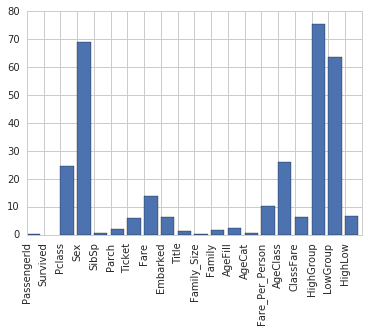

In [467]:
predictors = ['Pclass', 'Sex', 'Title', 'Fare',
       'Embarked', 'Title', 'Family_Size', 'Family', 'AgeFill',
       'AgeCat', 'Fare_Per_Person', 'AgeClass', 'ClassFare', 'HighLow', 'HighGroup', 'LowGroup']
best_feature(titanic, titanic.columns)

As we can see from the graph, Some of the most import features are HighGroup, LowGroup, Sex, AgeClass, Pclass, Fare, Fare_Per_Person, ClassFare, HighLow and Embarked. Then, we want to perform ensembling that we used before.

## Algorithms

Now that we have a bunch of good predictors, we want to train the data with our modeling tools, Gradient Boosting Classifier and Random Forest Classifier. I'm also going to try some other tools learned from
https://azure.microsoft.com/en-us/documentation/articles/machine-learning-algorithm-choice/
and
https://inclass.kaggle.com/c/deloitte-tackles-titanic/forums/t/9841/getting-high-scores-without-looking-at-actual-data-set

Also, I will try ensembling Random Forest Classifier with Support Vector Machines and Gradient Boosting Classifier.

In [468]:
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier

svc = svm.SVC(probability=True)
gbc = GradientBoostingClassifier(random_state=1, n_estimators=25, max_depth=3)
neigh = KNeighborsClassifier(n_neighbors=5)
rf = RandomForestClassifier(random_state=1, n_estimators=100, min_samples_split=20, min_samples_leaf=10)

# get all predictors so that we have a comprehensive training for gbc and rf
gbc_preds = ['Pclass', 'Sex', 'Title', 'Fare',
       'Embarked', 'Title', 'Family_Size', 'Family', 'AgeFill',
       'AgeCat', 'Fare_Per_Person', 'AgeClass', 'ClassFare', 'HighLow', 'HighGroup']
# choosing the highest features based on the graph
svc_preds = ['Pclass', 'Sex', 'Title', 'Family_Size', 'AgeCat', 'HighGroup']

print "GBC score: "
train_score(gbc, gbc_preds)
print "SVC score: "
train_score(svc, svc_preds)
print "KNN score: "
train_score(neigh, svc_preds)
print "RF score: "
train_score(rf, gbc_preds)

algs1 = [[gbc, gbc_preds], [svc, svc_preds]]
algs2 = [[rf, gbc_preds], [svc, svc_preds]]
print "Ensembled score: "
ensemble_train(algs2, 1, 1)

submission(ensemble_test(algs2, 1, 1))

GBC score: 
0.81593714927
SVC score: 
0.836139169473
KNN score: 
0.810325476992
RF score: 
0.830527497194
Ensembled score: 
0.828282828283


/home/yuzhong/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:48: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index


By ensembling svc with Gradient Boosting Classifier, or ensembling svc with Random Forest Classifier. I got a score of 0.79426 in Kaggle! But there is still a lot to improve. Next step is to further exploring features and create some new features based on the exploration

## Further Exploration of features
Now I have enough tools and models to work with, I need to further analyze all the features to help algorithms to better fit the data.

This section includes additional data exploration and adding new features to dataset

Sources that I draw inspiration from:
https://www.kaggle.com/omarelgabry/titanic/a-journey-through-titanic/notebook

In [469]:
# import data again for exploration use
titanic_df = pd.read_csv("train.csv", dtype={"Age": np.float64}, )
test_df    = pd.read_csv("test.csv", dtype={"Age": np.float64}, )

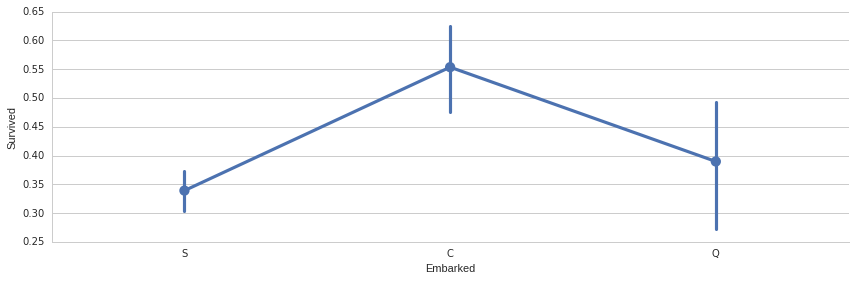

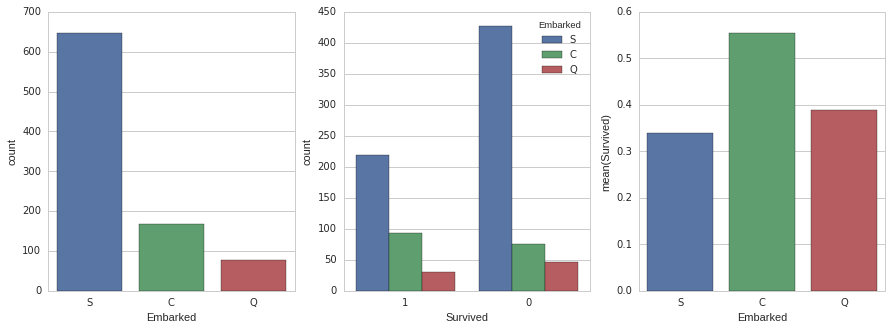

In [470]:
# Embarked

# only in titanic_df, fill the two missing values with the most occurred value, which is "S".
titanic_df["Embarked"] = titanic_df["Embarked"].fillna("S")

# plot
sns.factorplot('Embarked','Survived', data=titanic_df,size=4,aspect=3)

fig, (axis1,axis2,axis3) = plt.subplots(1,3,figsize=(15,5))

# sns.factorplot('Embarked',data=titanic_df,kind='count',order=['S','C','Q'],ax=axis1)
# sns.factorplot('Survived',hue="Embarked",data=titanic_df,kind='count',order=[1,0],ax=axis2)
sns.countplot(x='Embarked', data=titanic_df, ax=axis1)
sns.countplot(x='Survived', hue="Embarked", data=titanic_df, order=[1,0], ax=axis2)

# group by embarked, and get the mean for survived passengers for each value in Embarked
embark_perc = titanic_df[["Embarked", "Survived"]].groupby(['Embarked'],as_index=False).mean()
sns.barplot(x='Embarked', y='Survived', data=embark_perc,order=['S','C','Q'],ax=axis3)

# Either to consider Embarked column in predictions,
# and remove "S" dummy variable, 
# and leave "C" & "Q", since they seem to have a good rate for Survival.

# OR, don't create dummy variables for Embarked column, just drop it, 
# because logically, Embarked doesn't seem to be useful in prediction.


titanic_df = titanic_df.join(embark_dummies_titanic)
test_df    = test_df.join(embark_dummies_test)

As wee can see from the graphs, survival rate of these groups does vary, but the survival rate's difference is not large enough(groups with survival rate larger than 80% and smaller than 20% are helpful for our existing model). So I will further explore the age and sex of people in group 'S' to see if I can find a group that has low survival rate

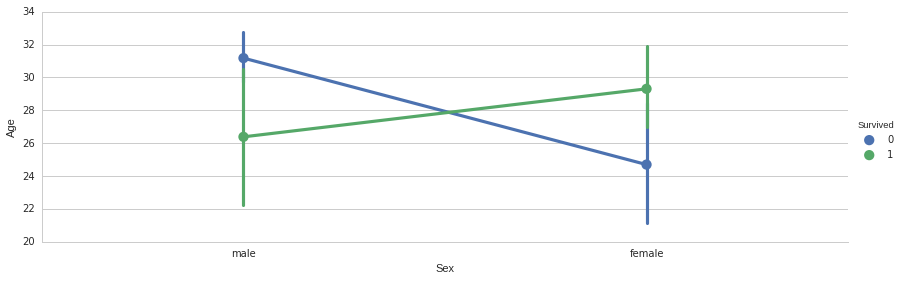

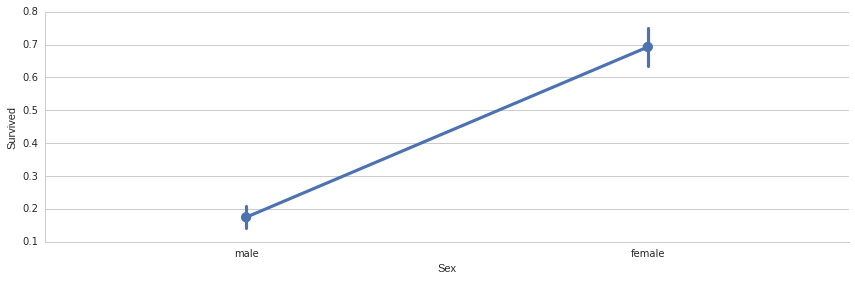

In [471]:
# plot
sns.factorplot('Sex', 'Age', 'Survived', data=titanic_df[titanic_df['Embarked'] == 'S'],size=4,aspect=3)
sns.factorplot('Sex', 'Survived', data=titanic_df[titanic_df['Embarked'] == 'S'],size=4,aspect=3)


Male with 'Embarked' 'S' is definitely a low survival rate group. But together with Age, we can see that male with 'Embarked' 'S' can be further divided into adult and children. So let's seperate the group based on age.

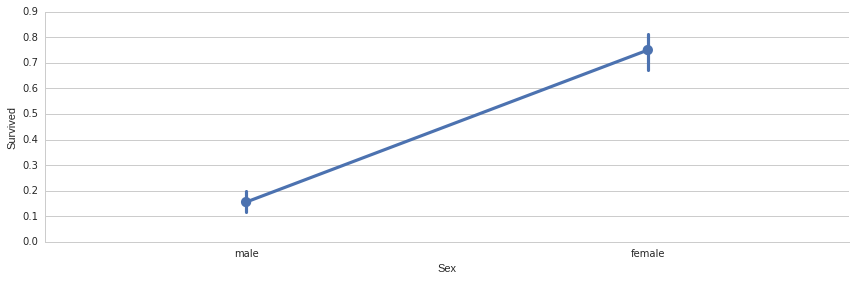

In [472]:
conditions = (titanic_df['Embarked'] == 'S') & (titanic_df['Age'] > 18.0)
sns.factorplot('Sex', 'Survived', data=titanic_df[conditions],size=4,aspect=3)

From this graph, we knows that male adults embarked at 'S' is a low survival rate group(about only 15 percent). Thus we will add this group to a new feature 'LowGroup' to our function clean_and_munge_data. To save time and space, I modified the function from above instead of redefining it below.

In [473]:
# re-reading train and test data
titanic = pd.read_csv("train.csv")
titanic_test = pd.read_csv("test.csv")

titanic = clean_and_munge_data(titanic)
titanic.drop(['PassengerId'], axis=1)
titanic_test = clean_and_munge_data(titanic_test)

In [474]:
svc = svm.SVC(probability=True)
gbc = GradientBoostingClassifier(random_state=1, n_estimators=25, max_depth=3)
neigh = KNeighborsClassifier(n_neighbors=5)
rf = RandomForestClassifier(random_state=1, n_estimators=500, min_samples_split=40, min_samples_leaf=20)
lr = LogisticRegression(random_state=1)

# get all predictors so that we have a comprehensive training for gbc and rf
gbc_preds = ['Pclass', 'Sex', 'Title', 'Fare',
       'Embarked', 'Title', 'Family_Size', 'Family', 'AgeFill',
       'AgeCat', 'Fare_Per_Person', 'AgeClass', 'ClassFare', 'HighLow', 'HighGroup']
# choosing the highest features based on the graph
svc_preds = ['Pclass', 'Sex', 'Title', 'Family_Size', 'AgeCat', 'HighGroup', 'LowGroup']

print "GBC score: "
train_score(gbc, gbc_preds)
print "SVC score: "
train_score(svc, svc_preds)
print "KNN score: "
train_score(neigh, svc_preds)
# print "RF score: "
# train_score(rf, gbc_preds)
print "LR score: "
train_score(lr, svc_preds)

algs1 = [[gbc, gbc_preds], [svc, svc_preds]]
algs2 = [[rf, gbc_preds], [svc, svc_preds]]
algs3 = [[lr, svc_preds], [svc, svc_preds]]
print "Ensembled score: "
ensemble_train(algs3, 1, 2)

svc.fit(titanic[svc_preds], titanic['Survived'])

submission(svc.predict(titanic_test[svc_preds]))

GBC score: 
0.81593714927
SVC score: 
0.832772166105
KNN score: 
0.800224466891
LR score: 
0.803591470258
Ensembled score: 
0.829405162738


/home/yuzhong/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:48: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index


The score in our training set improves a little, but the score in Kaggle does not change. It is still 0.79426. I think it is because the information provided by lowgroup is already covered by the data, therefore there is not much change in the model ny justing adding lowgroup to the data

## Future Steps

Data features can definitely be further explored and further cleaned to help modeling. Another thing I could do is to transform all the data into booleans to capture the essentials from the data while keeping away the noise. Also, random forest works better with binary data than numerical values. However, I may still want another copy with numerical datas to train SVM and finally ensembled with Random Forest, so that I won't lose information about the original data. 

